### In this script, DBN is run on the combined sessions, combined for each condition
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, DBN is run with sucessful and failed pulls seperately
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [13]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [14]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [15]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [16]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [17]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [18]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [19]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [20]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [21]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [22]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [23]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 5*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# session list options
do_bestsession = 1 # only analyze the best (five) sessions for each conditions during the training phase
do_trainedMCs = 1 # the list that only consider trained (1s) MC, together with SR and NV as controls
if do_bestsession:
    if not do_trainedMCs:
        savefile_sufix = '_bestsessions'
    elif do_trainedMCs:
        savefile_sufix = '_trainedMCsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 1:
    if not do_bestsession:
        dates_list = [
            
                     ]
        session_start_times = [ 
            
                              ] # in second
    elif do_bestsession:
        if not do_trainedMCs:
            # pick only five sessions for each conditions during the training phase
            dates_list = [
                          # "20220912",
                          "20220915","20220920","20221010","20230208",
                          "20221011","20221013","20221015","20221017",
                          "20221022","20221026","20221028","20221030","20230209",
                          "20221125","20221128","20221129","20230214","20230215",                  
                          "20221205","20221206","20221209","20221214","20230112",
                          "20230117","20230118","20230124",
                          # "20230126",
                         ]
            session_start_times = [ 
                                    # 18.10, 
                                     0.00, 33.03,  6.50,  0.00, 
                                     2.80, 27.80, 27.90, 27.00,  
                                    51.90, 21.00, 30.80, 17.50,  0.00,                    
                                    26.40, 22.50, 28.50,  0.00, 33.00,                     
                                     0.00,  0.00, 21.70, 17.00, 14.20, 
                                     0.00,  0.00,  0.00, 
                                     # 0.00,  
                                  ] # in second
        elif do_trainedMCs:
            dates_list = [
                          "20220915","20220920","20221010","20230208", # SR
                          
                          "20230321","20230322","20230323","20230324","20230412","20230413", # trained MC
                          
                          "20230117","20230118","20230124", # NV 
                         ]
            session_start_times = [ 
                                     0.00, 33.03,  6.50,  0.00, 
                                     
                                     20.5,  21.4,  21.0,  24.5,  20.5,  26.6,
                    
                                     0.00,  0.00,  0.00,  
                                  ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
    
# eddie sparkle
if 0:
    if not do_bestsession:
        dates_list = [
                                    
                   ]
        session_start_times = [ 
                                 
                              ] # in second
    elif do_bestsession:   
        if not do_trainedMCs:
            # pick only five sessions for each conditions during the training phase
            dates_list = [
                          "20221122",  "20221125",  
                          "20221202",  "20221206",  "20230126",  "20230130",  "20230201",
                          "20230207",  "20230208-1","20230209",  "20230222",  "20230223-1",
                          "20230227-1","20230228-1","20230302-1","20230307-2","20230313",
                          "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
                          "20230331",  "20230403",  "20230404",  "20230405",  "20230406"
                       ]
            session_start_times = [ 
                                      8.00,  38.00, 
                                      9.50,   1.00, 38.00,  4.20,  3.80,
                                      9.00,   7.50,  8.50, 14.50,  7.80,
                                      8.00,   7.50,  8.00,  8.00,  4.00,
                                      7.00,   7.50,  5.50, 11.00,  9.00,
                                      4.50,   9.30, 25.50, 20.40, 21.30,
                                  ] # in second
        elif do_trainedMCs:
            dates_list = [
                          "20221122",  "20221125",  # sr
                
                          "20230410",  "20230411",  "20230412",  "20230413",  "20230616", # trained MC
                
                          "20230331",  "20230403",  "20230404",  "20230405",  "20230406", # nv
                       ]
            session_start_times = [ 
                                      8.00, 38.00, 
                
                                      23.2,  23.0,  21.2,  25.0,  23.0,   
                
                                      4.50,  9.30, 25.50, 20.40, 21.30,
                
                                  ] # in second
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
    
# ginger kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      
                   ]
        session_start_times = [ 
                                
                              ] # in second 
    elif do_bestsession:
        if not do_trainedMCs:
            # pick only five sessions for each conditions during the training phase
            dates_list = [
                          #"20230213",
                          "20230214","20230216",
                          "20230228","20230302","20230303","20230307",          
                          "20230314","20230315","20230316","20230317",
                          "20230301","20230320","20230321","20230322",
                          "20230323","20230412","20230413","20230517",
                          "20230522_ws","20230524","20230605_1","20230606","20230607"
                       ]
            session_start_times = [ 
                                    # 0.00, 
                                     0.00, 48.00, 
                                    23.00, 28.50, 34.00, 25.50, 
                                    25.50, 31.50, 28.00, 30.50,
                                     0.00,  0.00,  0.00,  0.00, 
                                     0.00,  0.00,  0.00,  0.00, 
                                     0.00,  0.00,  0.00,  0.00,  0.00,
                                  ] # in second 
        elif do_trainedMCs:
            dates_list = [
                          "20230214",   "20230216",  # SR
                          
                          "20230614",   "20230615",  "20230711","20230712", # trained MC
                
                          "20230522_ws","20230524","20230605_1","20230606","20230607", # nv  
                       ]
            session_start_times = [ 
                                     0.00, 48.00, 
                                    
                                     0.00,  0.00,  54.5,  24.7,
                
                                     0.00,  0.00,  0.00,  0.00,  0.00,
                                  ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

    
# dannon kanga
if 0:
    if not do_bestsession:
        dates_list = [
                    
                   ]
        session_start_times = [ 
                              
                              ] # in second 
    elif do_bestsession: 
        if not do_trainedMCs:
            # pick only five sessions for each conditions during the training phase
            dates_list = [
                          "20230718","20230720","20230914","20230726","20230727","20230809",
                          "20230810","20230811","20230814","20230816","20230829","20230907","20230915",
                          "20230918","20230926","20230928","20231002","20231010","20231011",
                          "20231013","20231020","20231024","20231025",
                       ]
            session_start_times = [ 
                                        0,    0,    0, 32.2, 27.2, 37.5,
                                     21.0, 21.5, 19.8, 32.0,    0,    0,   0, 
                                        0,    0,    0,    0,    0,    0,
                                        0,    0,    0,    0, 
                                  ] # in second 
        elif do_trainedMCs:
            dates_list = [
                          "20230718","20230720","20230914", # sr
                
                          "20231030","20231031","20231101","20231102","20240304","20240305", # trained MC
                
                          "20231011","20231013","20231020","20231024","20231025", # nv
                       ]
            session_start_times = [ 
                                       0,    0,    0,
                
                                    18.2, 14.0, 15.8, 15.2, 16.3, 37.9,
                
                                       0,    0,    0,    0,    0, 
                                  ] # in second 
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"

# Koala Vermelho
if 0:
    if not do_bestsession:
        dates_list = [
                     
                     ]
        session_start_times = [ 
                               
                              ] # in second
    elif do_bestsession:
        if not do_trainedMCs:
            # pick only five sessions for each conditions during the training phase
            dates_list = [
                          "20231222","20231226","20231227",  "20231229","20231230",
                          "20231231","20240102","20240104-2","20240105","20240108",
                          "20240109","20240115","20240116",  "20240117","20240118","20240119",
                          "20240207","20240208","20240209",  "20240212","20240213",
                          "20240214","20240215","20240216",  
                         ]
            session_start_times = [ 
                                    21.5,  0.00,  0.00,  0.00,  0.00, 
                                    0.00,  12.2,  0.00,  18.8,  31.2,  
                                    32.5,  0.00,  50.0,  0.00,  37.5,  29.5,
                                    58.5,  72.0,  0.00,  71.5,  70.5,
                                    86.8,  94.0,  65.0, 
                                  ] # in second
        elif do_trainedMCs:
            dates_list = [
                          "20231222","20231226","20231227", # SR
                          
                          "20240220","20240222","20240223","20240226", # trained MC
                 
                          "20240214","20240215","20240216",  # NV
                         ]
            session_start_times = [ 
                                    21.5,  0.00,  0.00, 
                                    
                                    68.8,  43.8,  13.2,  47.5,
                
                                    86.8,  94.0,  65.0, 
                                  ] # in second

    animal1_fixedorder = ['koala']
    animal2_fixedorder = ['vermelho']

    animal1_filename = "Koala"
    animal2_filename = "Vermelho"
    
#    
#dates_list = ["20221128"]
#session_start_times = [1.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'


    

In [24]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
        try: 
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
         # load behavioral results
        try:
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
        except:
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])


        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        # plot the tracking demo video
        if 0: 
            tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    

all data from all dates are loaded


#### redefine the tasktype and cooperation threshold to merge them together

In [25]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision

tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

### plot behavioral events interval to get a sense about time bin
#### only focus on pull_to_other_bhv_interval and other_bhv_to_pull_interval

[2.75222222 3.639      3.00148148 1.17300275 0.52825203 0.5128866
 0.45726872 1.59727273 0.96630728 1.0699115 ]
1.1437499999999998


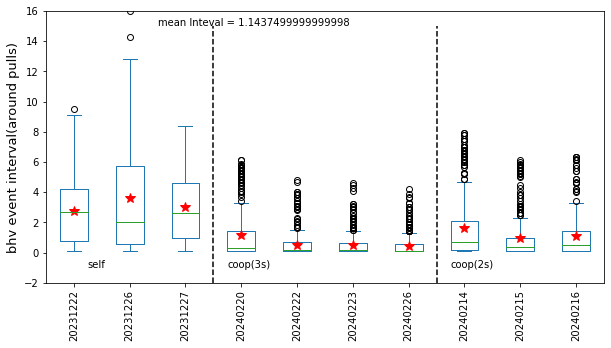

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pull_other_intv_forplots = {}
pull_other_intv_mean = np.zeros((1,ndates_sorted))[0]
pull_other_intv_ii = []
for ii in np.arange(0,ndates_sorted,1):
    pull_other_intv_ii = pd.Series(bhv_intv_all_dates[dates_list_sorted[ii]]['pull_other_pooled'])
    # remove the interval that is too large
    pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
    # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
    pull_other_intv_forplots[ii] = pull_other_intv_ii
    pull_other_intv_mean[ii] = np.nanmean(pull_other_intv_ii)
    
    
#
pull_other_intv_forplots = pd.DataFrame(pull_other_intv_forplots)

#
# plot
pull_other_intv_forplots.plot(kind = 'box',ax=ax1, positions=np.arange(0,ndates_sorted,1))
# plt.boxplot(pull_other_intv_forplots)
plt.plot(np.arange(0,ndates_sorted,1),pull_other_intv_mean,'r*',markersize=10)
#
ax1.set_ylabel("bhv event interval(around pulls)",fontsize=13)
ax1.set_ylim([-2,16])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-2,15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-1,tasktypes[itaskswitch],fontsize=10)
ax1.text(taskswitch-5,15,'mean Inteval = '+str(np.nanmean(pull_other_intv_forplots)),fontsize=10)

print(pull_other_intv_mean)
print(np.nanmean(pull_other_intv_forplots))

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"bhvInterval_hist_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

### prepare the input data for DBN

In [28]:
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,3,  3,3,5]
DBN_group_coopthres = [0,3,2,1.5,1,0]
if do_trainedMCs:
    DBN_group_typenames = ['self','coop(1s)','no-vision']
    DBN_group_typeIDs  =  [1,3,5]
    DBN_group_coopthres = [0,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]

pulltypes = ['succpull','failedpull']
npulltypes = np.shape(pulltypes)[0]

prepare_input_data = 1

DBN_input_data_alltypes = dict.fromkeys(pulltypes, [])

# DBN resolutions (make sure they are the same as in the later part of the code)
totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

mergetempRos = 0

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
    
    for ipulltype in np.arange(0,npulltypes,1):
        pulltype = pulltypes[ipulltype]

        DBN_input_data_alltypes[pulltype] = dict.fromkeys(DBN_group_typenames, [])
            
        for idate in np.arange(0,ndates,1):
            date_tgt = dates_list[idate]
            session_start_time = session_start_times[idate]
                 
            # load behavioral results
            try:
                try:
                    bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])
                except:
                    bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])
            except:
                try:
                    bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])
                except:
                    bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                    trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                    bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                    session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                    #
                    trial_record = pd.read_json(trial_record_json[0])
                    bhv_data = pd.read_json(bhv_data_json[0])
                    session_info = pd.read_json(session_info_json[0])

                
            # separate successful and failed pulls
            if pulltype == 'succpull':
                trialnum_tgtpull = trial_record[trial_record['rewarded']>0]['trial_number'].reset_index(drop=True)
            elif pulltype == 'failedpull':
                trialnum_tgtpull = trial_record[trial_record['rewarded']==0]['trial_number'].reset_index(drop=True)
            bhv_data = bhv_data[bhv_data['trial_number'].isin(trialnum_tgtpull)]
            trial_record = trial_record[trial_record['trial_number'].isin(trialnum_tgtpull)]
            bhv_data = bhv_data.reset_index(drop=True)
            trial_record = trial_record.reset_index(drop=True)
                
            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # clean up the trial_record
            #try:
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in trial_record['trial_number']:
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in trial_record_clean['trial_number']:
                ind = bhv_data["trial_number"]==itrial
                new_time_itrial = bhv_data[ind]["time_points"] + float(trial_record_clean[trial_record_clean['trial_number']==itrial]['trial_starttime'].iloc[0])
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]
            #except:
            #    trial_record_clean = trial_record

            # get task type and cooperation threshold
            try:
                coop_thres = session_info["pulltime_thres"][0]
                tasktype = session_info["task_type"][0]
            except:
                coop_thres = 0
                tasktype = 1

            # load behavioral event results
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            #
            look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
            look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
            look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
            # change the unit to second
            session_start_time = session_start_times[idate]
            look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

            # redefine the totalsess_time for the length of each recording (NOT! remove the session_start_time)
            totalsess_time = int(np.ceil(np.shape(look_at_other_or_not_merge['dodson'])[0]/fps))
            
            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']   


            if mergetempRos:
                temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
                # use bhv event to decide temporal resolution
                #
                #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)

            ntemp_reses = np.shape(temp_resolus)[0]           

            # try different temporal resolutions
            for temp_resolu in temp_resolus:
                bhv_df = []

                if np.isin(animal1,animal1_fixedorder):
                    bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                else:
                    bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     

                if len(bhv_df)==0:
                    bhv_df = bhv_df_itr
                else:
                    bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                    bhv_df = bhv_df.reset_index(drop=True)        

                # merge sessions from the same condition
                for iDBN_group in np.arange(0,nDBN_groups,1):
                    iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                    iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                    iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                    # merge sessions 
                    if (tasktype!=3):
                        if (tasktype==iDBN_group_typeID):
                            if (len(DBN_input_data_alltypes[pulltype][iDBN_group_typename])==0):
                                DBN_input_data_alltypes[pulltype][iDBN_group_typename] = bhv_df
                            else:
                                DBN_input_data_alltypes[pulltype][iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[pulltype][iDBN_group_typename],bhv_df])
                    else:
                        if (coop_thres==iDBN_group_cothres):
                            if (len(DBN_input_data_alltypes[pulltype][iDBN_group_typename])==0):
                                DBN_input_data_alltypes[pulltype][iDBN_group_typename] = bhv_df
                            else:
                                DBN_input_data_alltypes[pulltype][iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[pulltype][iDBN_group_typename],bhv_df])

    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)     

load social gaze with camera-2 only of 20231222
load social gaze with camera-2 only of 20231226
load social gaze with camera-2 only of 20231227
load social gaze with camera-2 only of 20240220
load social gaze with camera-2 only of 20240222
load social gaze with camera-2 only of 20240223
load social gaze with camera-2 only of 20240226
load social gaze with camera-2 only of 20240214
load social gaze with camera-2 only of 20240215
load social gaze with camera-2 only of 20240216
load social gaze with camera-2 only of 20231222
load social gaze with camera-2 only of 20231226
load social gaze with camera-2 only of 20231227
load social gaze with camera-2 only of 20240220
load social gaze with camera-2 only of 20240222
load social gaze with camera-2 only of 20240223
load social gaze with camera-2 only of 20240226
load social gaze with camera-2 only of 20240214
load social gaze with camera-2 only of 20240215
load social gaze with camera-2 only of 20240216


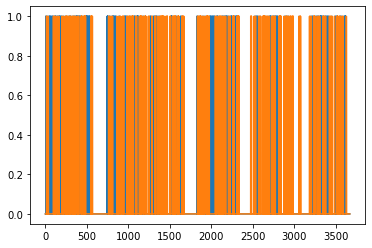

In [29]:
temp_resolu = 1
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
if not mergetempRos:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes = pickle.load(f)
else:
    with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes = pickle.load(f)
plt.plot(DBN_input_data_alltypes['succpull']['coop(1s)']['pull1_t0'].reset_index(drop=True))       
plt.plot(DBN_input_data_alltypes['failedpull']['coop(1s)']['pull1_t0'].reset_index(drop=True))

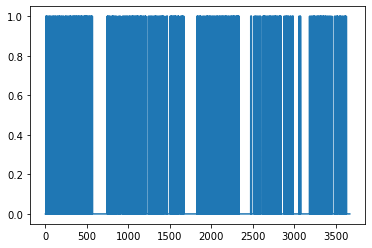

In [30]:
temp_resolu = 1
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
if not mergetempRos:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes = pickle.load(f)
else:
    with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes = pickle.load(f)
plt.plot(DBN_input_data_alltypes['coop(1s)']['pull1_t0'].reset_index(drop=True))


### run the DBN model on the combined session data set

In [31]:
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,3,  3,3,5]
DBN_group_coopthres = [0,3,2,1.5,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]

pulltypes = ['succpull','failedpull']
npulltypes = np.shape(pulltypes)[0]

#### a test run

In [32]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 1 # number of random starting points/graphs
nbootstraps = 1

if 0:

    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # analyze successful pull and failed pull separately
    for pulltype in pulltypes:
        
        # try different temporal resolutions, remember to use the same settings as in the previous ones
        for temp_resolu in temp_resolus:

            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
            if not mergetempRos:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            
            DBN_input_data_alltypes = DBN_input_data_alltypes[pulltype]

            # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)

            if not moreSampSize:
                key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
                key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
                key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
                min_samplesize = np.nanmin(key_to_value_lengths_array)
                min_samplesize = int(min_samplesize/100)*100
                max_samplesize = np.nanmax(key_to_value_lengths_array)
                max_samplesize = int(max_samplesize/100)*100
                samplingsizes = [min_samplesize,max_samplesize]
                samplingsizes_name = ['min_row_number','max_row_number']   
                nsamplings = np.shape(samplingsizes)[0]
                print(samplingsizes)

            # try different down/re-sampling size
            # for jj in np.arange(0,nsamplings,1):
            for jj in np.arange(0,1,1):

                isamplingsize = samplingsizes[jj]

                DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
                DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
                DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
                DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

                weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
                weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
                sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

                # different session conditions (aka DBN groups)
                # for iDBN_group in np.arange(0,nDBN_groups,1):
                for iDBN_group in np.arange(0,1,1):
                    iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                    iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                    iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                    try:
                        bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                        bhv_df_all = bhv_df_all.reset_index(drop=True)
                        # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                        #Anirban(Alec) shuffle, slow
                        # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                        # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                        colnames = list(bhv_df_all.columns)
                        eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                        nevents = np.size(eventnames)

                        all_pops = list(bhv_df_all.columns)
                        from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                        to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                        causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                        nFromNodes = np.shape(from_pops)[0]
                        nToNodes = np.shape(to_pops)[0]

                        DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                        DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                        score_randstart = np.zeros((num_starting_points))
                        score_randstart_shuffle = np.zeros((num_starting_points))

                        # step 1: randomize the starting point for num_starting_points times
                        for istarting_points in np.arange(0,num_starting_points,1):

                            # try different down/re-sampling size
                            bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                            aic = AicScore(bhv_df)

                            #Anirban(Alec) shuffle, slow
                            bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                            aic_shuffle = AicScore(bhv_df_shuffle)

                            np.random.seed(istarting_points)
                            random.seed(istarting_points)
                            starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                            starting_graph = DAG()
                            starting_graph.add_nodes_from(nodes=all_pops)
                            starting_graph.add_edges_from(ebunch=starting_edges)

                            best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                            DAGs[0][np.isnan(DAGs[0])]=0

                            DAGs_randstart[istarting_points,:,:] = DAGs[0]
                            score_randstart[istarting_points] = aic.score(best_model)

                            # step 2: add the shffled data results
                            # shuffled bhv_df
                            best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                            DAGs[0][np.isnan(DAGs[0])]=0

                            DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                            score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                        DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                        DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                        DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                        DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                        weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                        weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                        sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                        weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                        weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                        sig_edges_alltypes[iDBN_group_typename] = sig_edges

                    except:
                        DAGs_alltypes[iDBN_group_typename] = [] 
                        DAGs_shuffle_alltypes[iDBN_group_typename] = []

                        DAGs_scores_alltypes[iDBN_group_typename] = []
                        DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                        weighted_graphs_alltypes[iDBN_group_typename] = []
                        weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                        sig_edges_alltypes[iDBN_group_typename] = []

                DAGscores_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
                DAGscores_shuffled_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

                weighted_graphs_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
                weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
                sig_edges_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

    print(weighted_graphs_diffTempRo_diffSampSize)
            
   

#### run on the entire population

In [ ]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 100 # number of random starting points/graphs
nbootstraps = 95

try:
    # dumpy
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

except:
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

     # analyze successful pull and failed pull separately
    for pulltype in pulltypes:
        
        # try different temporal resolutions, remember to use the same settings as in the previous ones
        for temp_resolu in temp_resolus:

            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
            if not mergetempRos:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            else:
                with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            #        
            DBN_input_data_alltypes = DBN_input_data_alltypes[pulltype]

            # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)

            if not moreSampSize:
                key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
                key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
                key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
                min_samplesize = np.nanmin(key_to_value_lengths_array)
                min_samplesize = int(min_samplesize/100)*100
                max_samplesize = np.nanmax(key_to_value_lengths_array)
                max_samplesize = int(max_samplesize/100)*100
                # samplingsizes = [min_samplesize,max_samplesize]
                samplingsizes = [min_samplesize]
                # samplingsizes_name = ['min_row_number','max_row_number'] 
                samplingsizes_name = ['min_row_number'] 
                nsamplings = np.shape(samplingsizes)[0]
                print(samplingsizes)

            # try different down/re-sampling size
            for jj in np.arange(0,nsamplings,1):

                isamplingsize = samplingsizes[jj]

                DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
                DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
                DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
                DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

                weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
                weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
                sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

                # different session conditions (aka DBN groups)
                for iDBN_group in np.arange(0,nDBN_groups,1):
                    iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                    iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                    iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                    try:
                        bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                        bhv_df_all = bhv_df_all.reset_index(drop=True)
                        # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                        #Anirban(Alec) shuffle, slow
                        # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                        # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                        colnames = list(bhv_df_all.columns)
                        eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                        nevents = np.size(eventnames)

                        all_pops = list(bhv_df_all.columns)
                        from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                        to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                        causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                        nFromNodes = np.shape(from_pops)[0]
                        nToNodes = np.shape(to_pops)[0]

                        DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                        DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                        score_randstart = np.zeros((num_starting_points))
                        score_randstart_shuffle = np.zeros((num_starting_points))

                        # step 1: randomize the starting point for num_starting_points times
                        for istarting_points in np.arange(0,num_starting_points,1):

                            # try different down/re-sampling size
                            bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                            aic = AicScore(bhv_df)

                            #Anirban(Alec) shuffle, slow
                            bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                            aic_shuffle = AicScore(bhv_df_shuffle)

                            np.random.seed(istarting_points)
                            random.seed(istarting_points)
                            starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                            starting_graph = DAG()
                            starting_graph.add_nodes_from(nodes=all_pops)
                            starting_graph.add_edges_from(ebunch=starting_edges)

                            best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                            DAGs[0][np.isnan(DAGs[0])]=0

                            DAGs_randstart[istarting_points,:,:] = DAGs[0]
                            score_randstart[istarting_points] = aic.score(best_model)

                            # step 2: add the shffled data results
                            # shuffled bhv_df
                            best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                            DAGs[0][np.isnan(DAGs[0])]=0

                            DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                            score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                        DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                        DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                        DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                        DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                        weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                        weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                        sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                        weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                        weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                        sig_edges_alltypes[iDBN_group_typename] = sig_edges

                    except:
                        DAGs_alltypes[iDBN_group_typename] = [] 
                        DAGs_shuffle_alltypes[iDBN_group_typename] = []

                        DAGs_scores_alltypes[iDBN_group_typename] = []
                        DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                        weighted_graphs_alltypes[iDBN_group_typename] = []
                        weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                        sig_edges_alltypes[iDBN_group_typename] = []

                DAGscores_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
                DAGscores_shuffled_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

                weighted_graphs_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
                weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
                sig_edges_diffTempRo_diffSampSize[(pulltype,str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
    # save data
    savedata = 1
    if savedata:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
        if moreSampSize:  
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
                pickle.dump(sig_edges_diffTempRo_diffSampSize, f)

        else:
            with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
                pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


In [ ]:
# for self condition, use the same for failed pull and succ pull
# DAGscores_diffTempRo_diffSampSize[('failedpull', '1', 'max_row_number')]['self']=DAGscores_diffTempRo_diffSampSize[('succpull', '1', 'max_row_number')]['self']
# DAGscores_shuffled_diffTempRo_diffSampSize[('failedpull', '1', 'max_row_number')]['self']=DAGscores_shuffled_diffTempRo_diffSampSize[('succpull', '1', 'max_row_number')]['self']
# weighted_graphs_diffTempRo_diffSampSize[('failedpull', '1', 'max_row_number')]['self']=weighted_graphs_diffTempRo_diffSampSize[('succpull', '1', 'max_row_number')]['self']
# weighted_graphs_shuffled_diffTempRo_diffSampSize[('failedpull', '1', 'max_row_number')]['self']=weighted_graphs_shuffled_diffTempRo_diffSampSize[('succpull', '1', 'max_row_number')]['self']
# sig_edges_diffTempRo_diffSampSize[('failedpull', '1', 'max_row_number')]['self']=sig_edges_diffTempRo_diffSampSize[('succpull', '1', 'max_row_number')]['self']

DAGscores_diffTempRo_diffSampSize[('failedpull', '1', 'min_row_number')]['self']=DAGscores_diffTempRo_diffSampSize[('succpull', '1', 'min_row_number')]['self']
DAGscores_shuffled_diffTempRo_diffSampSize[('failedpull', '1', 'min_row_number')]['self']=DAGscores_shuffled_diffTempRo_diffSampSize[('succpull', '1', 'min_row_number')]['self']
weighted_graphs_diffTempRo_diffSampSize[('failedpull', '1', 'min_row_number')]['self']=weighted_graphs_diffTempRo_diffSampSize[('succpull', '1', 'min_row_number')]['self']
weighted_graphs_shuffled_diffTempRo_diffSampSize[('failedpull', '1', 'min_row_number')]['self']=weighted_graphs_shuffled_diffTempRo_diffSampSize[('succpull', '1', 'min_row_number')]['self']
sig_edges_diffTempRo_diffSampSize[('failedpull', '1', 'min_row_number')]['self']=sig_edges_diffTempRo_diffSampSize[('succpull', '1', 'min_row_number')]['self']






### plot graphs - show the edge with arrows; show the best time bin and row number; show the three time lag separately

In [ ]:
# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,5]
DBN_group_coopthres = [0,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]

pulltype_forplot = 'succpull' # 'succpull' or 'failedpull'

# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

# make sure these variables are consistent with the train_DBN_alec.py settings
# eventnames = ["pull1","pull2","gaze1","gaze2"]
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
# eventnodes_color = ['b','r','y','g']
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00']
eventnodes_shape = ["o","o","^","^"]
    
savefigs = 1

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,nDBN_groups)
fig.set_figheight(48)
fig.set_figwidth(8*nDBN_groups)

time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[[0,1,2,3],[4,5,6,7],[8,9,10,11]]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    

for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:

            iDBN_group_typename = DBN_group_typenames[iDBN_group]

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
            #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)
            
            sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt
            sig_avg_dags = sig_avg_dags[fromRowID,:]

            # plot
            axs[ilag*2+0,iDBN_group].set_title(pulltype_forplot+' '+iDBN_group_typename,fontsize=18)
            axs[ilag*2+0,iDBN_group].set_xlim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_ylim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_xticks([])
            axs[ilag*2+0,iDBN_group].set_xticklabels([])
            axs[ilag*2+0,iDBN_group].set_yticks([])
            axs[ilag*2+0,iDBN_group].set_yticklabels([])
            axs[ilag*2+0,iDBN_group].spines['top'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['right'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['bottom'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['left'].set_visible(False)
            # axs[ilag*2+0,iDBN_group].axis('equal')

            
            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],
                                              eventnodes_shape[ieventnode],markersize=60,markerfacecolor=eventnodes_color[ieventnode],
                                              markeredgecolor='none')              
                #axs[ilag*2+0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                #                       eventnames[ieventnode],fontsize=15)
                
                clmap = mpl.cm.get_cmap('Greens')
                
                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt>0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        # head_width=0.08*abs(edge_weight_tgt),
                                                        # width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,   
                                                        color = clmap(edge_weight_tgt))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt),
                                                      0.04,
                                                      color = clmap(edge_weight_tgt))
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap(edge_weight_tgt), 
                                    edgecolor=clmap(edge_weight_tgt)
                                )
                                axs[ilag*2+0,iDBN_group].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                else:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = 0,1
            import matplotlib as mpl
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="Greens",norm=norm)
            #
            if iDBN_group == nDBN_groups-1:
                cax = axs[ilag*2+1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,iDBN_group], cax=cax,label='edge confidence')

            axs[ilag*2+1,iDBN_group].axis('equal')
            axs[ilag*2+1,iDBN_group].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
            axs[ilag*2+1,iDBN_group].set_xticklabels(eventnames)
            if iDBN_group == 0:
                axs[ilag*2+1,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
                axs[ilag*2+1,iDBN_group].set_yticklabels(eventnames)
                axs[ilag*2+1,iDBN_group].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,iDBN_group].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,iDBN_group].set_yticks([])
                axs[ilag*2+1,iDBN_group].set_yticklabels([])

        except:
            continue
    
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+pulltype_forplot+"_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:  
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+pulltype_forplot+"_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
            
            
            

### plot graphs - show the edge differences, use one condition as the base

In [ ]:
# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,5]
DBN_group_coopthres = [0,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]

pulltype_forplot = 'failedpull' # 'succpull' or 'failedpull'

# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

basecondition = 'coop(1s)'

# make sure these variables are consistent with the train_DBN_alec.py settings
# eventnames = ["pull1","pull2","gaze1","gaze2"]
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
# eventnodes_color = ['b','r','y','g']
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00']
eventnodes_shape = ["o","o","^","^"]

nFromNodes = nevents
nToNodes = nevents
    
savefigs = 1

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,nDBN_groups)
fig.set_figheight(48)
fig.set_figwidth(8*nDBN_groups)

time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[[0,1,2,3],[4,5,6,7],[8,9,10,11]]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    
    
weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][basecondition]
weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][basecondition]
#sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][basecondition]
sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
# sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

weighted_graphs_base = weighted_graphs_tgt

sig_edges_base = sig_edges_tgt

sig_avg_dags_base =  weighted_graphs_base.mean(axis = 0) * sig_edges_base
    
    
for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
       
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:

            iDBN_group_typename = DBN_group_typenames[iDBN_group]


            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
            #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)
            
            if 0:
                weighted_graphs_delta = (weighted_graphs_tgt-weighted_graphs_base)
                weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
                #
                sig_edges_delta = ((sig_edges_tgt+sig_edges_base)>0)*1
            else:
                weighted_graphs_delta,sig_edges_delta = Modulation_Index(weighted_graphs_base, weighted_graphs_tgt,
                                                                         sig_edges_base, sig_edges_tgt, 8000)
                weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
                
            sig_avg_dags = weighted_graphs_delta * sig_edges_delta
            sig_avg_dags = sig_avg_dags[fromRowID,:]

            # plot
            axs[ilag*2+0,iDBN_group].set_title(iDBN_group_typename,fontsize=18)
            axs[ilag*2+0,iDBN_group].set_xlim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_ylim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_xticks([])
            axs[ilag*2+0,iDBN_group].set_xticklabels([])
            axs[ilag*2+0,iDBN_group].set_yticks([])
            axs[ilag*2+0,iDBN_group].set_yticklabels([])
            axs[ilag*2+0,iDBN_group].spines['top'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['right'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['bottom'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['left'].set_visible(False)
            # axs[ilag*2+0,iDBN_group].axis('equal')

            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],
                                              eventnodes_shape[ieventnode],markersize=60,markerfacecolor=eventnodes_color[ieventnode],
                                              markeredgecolor='none')              
                
                #axs[ilag*2+0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                #                       eventnames[ieventnode],fontsize=10)
                
                clmap = mpl.cm.get_cmap('bwr')
                
                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt!=0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        # head_width=0.08*abs(edge_weight_tgt),
                                                        # width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,       
                                                        color = clmap((1+edge_weight_tgt)/2))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt)
                                                      0.04
                                                     )
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap((1+edge_weight_tgt)/2), 
                                    edgecolor=clmap((1+edge_weight_tgt)/2)
                                )
                                axs[ilag*2+0,iDBN_group].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap((1+edge_weight_tgt)/2),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                else:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap((1+edge_weight_tgt)/2),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = -1,1
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="bwr",norm=norm)
            #-
            if iDBN_group == nDBN_groups-1:
                cax = axs[ilag*2+1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,iDBN_group], cax=cax,label='edge confidence')

            axs[ilag*2+1,iDBN_group].axis('equal')
            axs[ilag*2+1,iDBN_group].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
            axs[ilag*2+1,iDBN_group].set_xticklabels(eventnames)
            if iDBN_group == 0:
                axs[ilag*2+1,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
                axs[ilag*2+1,iDBN_group].set_yticklabels(eventnames)
                axs[ilag*2+1,iDBN_group].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,iDBN_group].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,iDBN_group].set_yticks([])
                axs[ilag*2+1,iDBN_group].set_yticklabels([])

        except:
            continue
    
    
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+pulltype_forplot+"_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
    else:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+pulltype_forplot+"_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
            
            
            

## Plots that include all pairs

### VERSION 4: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis averaged the MI among time lag and show CI

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','v','^','*']
#animal1_fixedorders = ['eddie']
#animal2_fixedorders = ['sparkle']
#animalpairs_datashapes = ['o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

pulltype_forplot = 'failedpull' # 'succpull' or 'failedpull'

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(10)
fig.set_figwidth(5*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    pull_pull_fromNodes_all = [0,1,4,5,8,9]
    pull_pull_toNodes_all = [1,0,1,0,1,0]
    #
    gaze_gaze_fromNodes_all = [2,3,6,7,10,11]
    gaze_gaze_toNodes_all = [3,2,3,2,3,2]
    #
    within_pullgaze_fromNodes_all = [0,1,4,5,8,9]
    within_pullgaze_toNodes_all = [2,3,2,3,2,3]
    #
    across_pullgaze_fromNodes_all = [0,1,4,5,8,9]
    across_pullgaze_toNodes_all = [3,2,3,2,3,2]
    #
    within_gazepull_fromNodes_all = [2,3,6,7,10,11]
    within_gazepull_toNodes_all = [0,1,0,1,0,1]
    #
    across_gazepull_fromNodes_all = [2,3,6,7,10,11]
    across_gazepull_toNodes_all = [1,0,1,0,1,0]

    
    # plot coop self modulation
    
    # pull-pull
    xxx1 = np.mean(MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    # err1 = np.std(MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    err1 = st.sem(MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten())
    axs[0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 5)
    line1 = axs[0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    xxx2 = np.mean(MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    # err2 = np.std(MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    err2 = st.sem(MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all].flatten())
    axs[0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 5)
    line2 = axs[0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    xxx3 = np.mean(MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    # err3 = np.std(MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    err3 = st.sem(MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all].flatten())
    axs[0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 5)
    line3 = axs[0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    xxx4 = np.mean(MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    # err4 = np.std(MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    err4 = st.sem(MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all].flatten())
    axs[0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 5)
    line4 = axs[0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    xxx5 = np.mean(MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    #err5 = np.std(MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    err5 = st.sem(MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all].flatten())
    axs[0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 5)
    line5 = axs[0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    xxx6 = np.mean(MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    # err6 = np.std(MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    err6 = st.sem(MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all].flatten())
    axs[0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 5)
    line6 = axs[0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[0,iplot].set_xlim([-0.1,nanimalpairs-0.9])
        axs[0,iplot].set_ylim([-1.05,1.05])
        axs[0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        axs[0,iplot].set_xticklabels([])
        axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
        #
        if iplot == 0:
            axs[0,iplot].tick_params(axis='y', labelsize=13)
            axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
        else:
            axs[0,iplot].set_yticklabels([])
        axs[0,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

    # plot novision coop modulation
    # pull-pull
    xxx1 = np.mean(MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    # err1 = np.std(MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    err1 = st.sem(MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten())
    axs[1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 5)
    line1 = axs[1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    xxx2 = np.mean(MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    # err2 = np.std(MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    err2 = st.sem(MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all].flatten())
    axs[1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 5)
    line2 = axs[1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    xxx3 = np.mean(MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    # err3 = np.std(MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    err3 = st.sem(MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all].flatten())
    axs[1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 5)
    line3 = axs[1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    xxx4 = np.mean(MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    # err4 = np.std(MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    err4 = st.sem(MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all].flatten())
    axs[1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 5)
    line4 = axs[1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    xxx5 = np.mean(MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    #err5 = np.std(MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    err5 = st.sem(MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all].flatten())
    axs[1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 5)
    line5 = axs[1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    xxx6 = np.mean(MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    # err6 = np.std(MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    err6 = st.sem(MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all].flatten())
    axs[1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 5)
    line6 = axs[1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[1,iplot].set_xlim([-0.1,nanimalpairs-0.9])
        axs[1,iplot].set_ylim([-1.05,1.05])
        axs[1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        #axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
        axs[1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
        #axs[1,iplot].set_xlabel('time lag',fontsize=15)
        axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
        if iplot == 0:
            axs[1,iplot].tick_params(axis='y', labelsize=13)
            axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
        else:
            axs[1,iplot].set_yticklabels([])
        axs[1,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[1,iplot].plot([-1,nanimalpairs],[0,0],'k--')
        
    #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
    #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
    #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)
    
savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_meanSEM.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_meanSEM.pdf')
           
    

### version 5: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis averaged the MI only for 1s

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','v','^','*']
#animal1_fixedorders = ['eddie']
#animal2_fixedorders = ['sparkle']
#animalpairs_datashapes = ['o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

pulltype_forplot = 'failedpull' # 'succpull' or 'failedpull'

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(10)
fig.set_figwidth(5*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    pull_pull_fromNodes_all = [8,9]
    pull_pull_toNodes_all = [1,0]
    #
    gaze_gaze_fromNodes_all = [10,11]
    gaze_gaze_toNodes_all = [3,2]
    #
    within_pullgaze_fromNodes_all = [8,9]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [8,9]
    across_pullgaze_toNodes_all = [3,2]
    #
    within_gazepull_fromNodes_all = [10,11]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [10,11]
    across_gazepull_toNodes_all = [1,0]

    
    # plot coop self modulation
    
    # pull-pull
    a = MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten()
    xxx1 = np.mean(a)
    err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
    line1 = axs[0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all]).flatten()
    xxx2 = np.mean(a)
    err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
    line2 = axs[0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    a = (MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all]).flatten()
    xxx3 = np.mean(a)
    err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
    line3 = axs[0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    a = (MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all]).flatten()
    xxx4 = np.mean(a)
    err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
    line4 = axs[0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all]).flatten()
    xxx5 = np.mean(a)
    err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
    line5 = axs[0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all]).flatten()
    xxx6 = np.mean(a)
    err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
    line6 = axs[0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[0,iplot].set_xlim([-0.3,nanimalpairs-0.7])
        axs[0,iplot].set_ylim([-1.05,1.05])
        axs[0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        axs[0,iplot].set_xticklabels([])
        axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
        #
        if iplot == 0:
            axs[0,iplot].tick_params(axis='y', labelsize=13)
            axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
        else:
            axs[0,iplot].set_yticklabels([])
        axs[0,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

    # plot novision coop modulation
    # pull-pull
    a = MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten()
    xxx1 = np.mean(a)
    err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
    line1 = axs[1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all]).flatten()
    xxx2 = np.mean(a)
    err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
    line2 = axs[1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all]).flatten()
    xxx3 = np.mean(a)
    err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
    line3 = axs[1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all]).flatten()
    xxx4 = np.mean(a)
    err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
    line4 = axs[1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all]).flatten()
    xxx5 = np.mean(a)
    err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
    line5 = axs[1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all]).flatten()
    xxx6 = np.mean(a)
    err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
    line6 = axs[1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[1,iplot].set_xlim([-0.3,nanimalpairs-0.7])
        axs[1,iplot].set_ylim([-1.05,1.05])
        axs[1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        #axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
        axs[1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
        #axs[1,iplot].set_xlabel('time lag',fontsize=15)
        axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
        if iplot == 0:
            axs[1,iplot].tick_params(axis='y', labelsize=13)
            axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
        else:
            axs[1,iplot].set_yticklabels([])
        axs[1,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[1,iplot].plot([-1,nanimalpairs],[0,0],'k--')
        
    #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
    #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
    #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)
    
savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI.pdf')
           
    

### version 6: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis showed the MI; separate animal 1 and 2; merge time lags

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','v','^','*']
#animal1_fixedorders = ['eddie']
#animal2_fixedorders = ['sparkle']
#animalpairs_datashapes = ['o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

pulltype_forplot = 'succpull' # 'succpull' or 'failedpull'

#
fig, axs = plt.subplots(4,6)
fig.set_figheight(8*4)
fig.set_figwidth(8*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    
    #
    pull_pull_fromNodes_all = [[0,4,8],[1,5,9]]
    pull_pull_toNodes_all = [[1,1,1],[0,0,0]]
    #
    gaze_gaze_fromNodes_all = [[2,6,10],[3,7,11]]
    gaze_gaze_toNodes_all = [[3,3,3],[2,2,2]]
    #
    within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
    within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
    #
    across_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
    across_pullgaze_toNodes_all = [[3,3,3],[2,2,2]]
    #
    within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
    within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
    #
    across_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
    across_gazepull_toNodes_all = [[1,1,1],[0,0,0]]
    
    animalshortnames = ['A1','A2']

    
    for ianimal in np.arange(0,2,1):
        
        anishortname = animalshortnames[ianimal]
        
        
        # plot coop self modulation

        # pull-pull
        a = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        #
        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+0,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+0,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            axs[2*ianimal+0,iplot].set_xticklabels([])
            axs[2*ianimal+0,iplot].set_yticks([-1,-0.5,0,0.5,1])
            #
            if iplot == 0:
                axs[2*ianimal+0,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
            else:
                axs[2*ianimal+0,iplot].set_yticklabels([])
            axs[2*ianimal+0,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        # plot novision coop modulation
        # pull-pull
        a = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+1,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+1,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            #axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
            axs[2*ianimal+1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
            #axs[1,iplot].set_xlabel('time lag',fontsize=15)
            axs[2*ianimal+1,iplot].set_yticks([-1,-0.5,0,0.5,1])
            if iplot == 0:
                axs[2*ianimal+1,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
            else:
                axs[1,iplot].set_yticklabels([])
            axs[2*ianimal+1,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+1,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
        #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
        #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)

savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_IndiAnimal_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_IndiAnimal_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI.pdf')
           
    

### version 7: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis showed the MI; separate animal 1 and 2; only for 1s time lag

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','v','^','*']
#animal1_fixedorders = ['eddie']
#animal2_fixedorders = ['sparkle']
#animalpairs_datashapes = ['o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

pulltype_forplot = 'succpull' # 'succpull' or 'failedpull'

#
fig, axs = plt.subplots(4,6)
fig.set_figheight(8*4)
fig.set_figwidth(8*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    pull_pull_fromNodes_all = [8,9]
    pull_pull_toNodes_all = [1,0]
    #
    gaze_gaze_fromNodes_all = [10,11]
    gaze_gaze_toNodes_all = [3,2]
    #
    within_pullgaze_fromNodes_all = [8,9]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [8,9]
    across_pullgaze_toNodes_all = [3,2]
    #
    within_gazepull_fromNodes_all = [10,11]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [10,11]
    across_gazepull_toNodes_all = [1,0]

    animalshortnames = ['A1','A2']
    
    for ianimal in np.arange(0,2,1):
        
        anishortname = animalshortnames[ianimal]
        
        # plot coop self modulation

        # pull-pull
        a = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        #
        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+0,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+0,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            axs[2*ianimal+0,iplot].set_xticklabels([])
            axs[2*ianimal+0,iplot].set_yticks([-1,-0.5,0,0.5,1])
            #
            if iplot == 0:
                axs[2*ianimal+0,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
            else:
                axs[2*ianimal+0,iplot].set_yticklabels([])
            axs[2*ianimal+0,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        # plot novision coop modulation
        # pull-pull
        a = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+1,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+1,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            #axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
            axs[2*ianimal+1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
            #axs[1,iplot].set_xlabel('time lag',fontsize=15)
            axs[2*ianimal+1,iplot].set_yticks([-1,-0.5,0,0.5,1])
            if iplot == 0:
                axs[2*ianimal+1,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
            else:
                axs[2*ianimal+1,iplot].set_yticklabels([])
            axs[2*ianimal+1,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+1,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
        #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
        #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)

savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_IndiAnimal_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_IndiAnimal_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI.pdf')
           
    

### version 7-2-2: 
#### plot the key edges' modulation; 
#### only show the modulation among coop1s, self, no-vision; 
#### separate animal 1 and 2, plot individual animal; 
#### put all animal in one plot - based on the "to Node"; for one time lag or merged all time lags

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','o','o','o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

timelag = 1 # 1 or 2 or 3 or 0(merged)
timelagname = '1second' # '1/2/3second' or 'merged'
# timelagname = 'merged'

pulltype_forplot = 'succpull' # 'succpull' or 'failedpull'

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(8*2)
fig.set_figwidth(8*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    if timelag == 1:
        pull_pull_fromNodes_all = [9,8]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [11,10]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [8,9]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [9,8]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [10,11]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [11,10]
        across_gazepull_toNodes_all = [0,1]
        #
    elif timelag == 2:
        pull_pull_fromNodes_all = [5,4]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [7,6]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [4,5]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [5,4]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [6,7]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [7,6]
        across_gazepull_toNodes_all = [0,1]
        #
    elif timelag == 3:
        pull_pull_fromNodes_all = [1,0]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [3,2]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [0,1]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [1,0]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [2,3]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [3,2]
        across_gazepull_toNodes_all = [0,1]
        #
    elif timelag == 0:
        pull_pull_fromNodes_all = [[1,5,9],[0,4,8]]
        pull_pull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        gaze_gaze_fromNodes_all = [[3,7,11],[2,6,10]]
        gaze_gaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
        within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        across_pullgaze_fromNodes_all = [[1,5,9],[0,4,8]]
        across_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
        within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        across_gazepull_fromNodes_all = [[3,7,11],[2,6,10]]
        across_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
    
    
    for ianimal in np.arange(0,2,1):
                
        # plot coop self modulation

        # pull-pull
        a = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,0].errorbar(ianimal*nanimalpairs+ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[0,0].plot(ianimal*nanimalpairs+ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,1].errorbar(ianimal*nanimalpairs+ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[0,1].plot(ianimal*nanimalpairs+ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,2].errorbar(ianimal*nanimalpairs+ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[0,2].plot(ianimal*nanimalpairs+ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,3].errorbar(ianimal*nanimalpairs+ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[0,3].plot(ianimal*nanimalpairs+ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,4].errorbar(ianimal*nanimalpairs+ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[0,4].plot(ianimal*nanimalpairs+ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,5].errorbar(ianimal*nanimalpairs+ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[0,5].plot(ianimal*nanimalpairs+ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        #
        plottypes = ['To Node; across animal pull<->pull','To Node; across animal gaze<->gaze',
                     'To Node; within animal gaze->pull','To Node; across animal gaze->pull',
                     'To Node; within animal pull->gaze','To Node; across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[0,iplot].set_xlim([-0.3,nanimalpairs*2-0.7])
            axs[0,iplot].set_ylim([-1.05,1.05])
            axs[0,iplot].set_xticks(np.arange(0,nanimalpairs*2,1))
            axs[0,iplot].set_xticklabels(['E','Do','Da','G','Sp','Sc','K','K'],fontsize = 20)
            axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
            #
            if iplot == 0:
                axs[0,iplot].tick_params(axis='y', labelsize=13)
                axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=22)
            else:
                axs[0,iplot].set_yticklabels([])
            axs[0,iplot].set_title(plottypes[iplot],fontsize = 21)
            #
            if ianimalpair == nanimalpairs-1:
                axs[0,iplot].plot([-1,nanimalpairs*2],[0,0],'k--')

        # plot novision coop modulation
        # pull-pull
        a = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,0].errorbar(ianimal*nanimalpairs+ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[1,0].plot(ianimal*nanimalpairs+ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,1].errorbar(ianimal*nanimalpairs+ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[1,1].plot(ianimal*nanimalpairs+ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,2].errorbar(ianimal*nanimalpairs+ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[1,2].plot(ianimal*nanimalpairs+ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,3].errorbar(ianimal*nanimalpairs+ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[1,3].plot(ianimal*nanimalpairs+ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,4].errorbar(ianimal*nanimalpairs+ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[1,4].plot(ianimal*nanimalpairs+ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,5].errorbar(ianimal*nanimalpairs+ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[1,5].plot(ianimal*nanimalpairs+ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        plottypes = ['To Node; across animal pull<->pull','To Node; across animal gaze<->gaze',
                     'To Node; within animal gaze->pull','To Node; across animal gaze->pull',
                     'To Node; within animal pull->gaze','To Node; across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[1,iplot].set_xlim([-0.3,nanimalpairs*2-0.7])
            axs[1,iplot].set_ylim([-1.05,1.05])
            axs[1,iplot].set_xticks(np.arange(0,nanimalpairs*2,1))
            #axs[1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA'],fontsize = 13)
            axs[1,iplot].set_xticklabels(['E','Do','Da','G','Sp','Sc','K','K'],fontsize = 20)
            #axs[1,iplot].set_xlabel('time lag',fontsize=15)
            axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
            if iplot == 0:
                axs[1,iplot].tick_params(axis='y', labelsize=13)
                axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=22)
            else:
                axs[1,iplot].set_yticklabels([])
            axs[1,iplot].set_title(plottypes[iplot],fontsize = 21)
            #
            if ianimalpair == nanimalpairs-1:
                axs[1,iplot].plot([-1,nanimalpairs*2],[0,0],'k--')

        #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
        #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
        #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)

savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI_version3.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI_version3.pdf')
           
    

### version 7-2-3-2:
#### plot the key edges' modulation; 
#### only show the modulation among coop1s, self, no-vision; 
#### separate animal 1 and 2, plot individual animal; 
#### pool 1) all the animals, 2) male and female, 3) subordinate and dominant

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
animal_pooled_list = ['E','SP','DO','SC','DA','KwDA','G','KwG','K','V']

nanimalpairs = np.shape(animal1_fixedorders)[0]
nanimalpooled = np.shape(animal_pooled_list)[0]

timelag = 12 # 1 or 2 or 3 or 0(merged - merge all three lags) or 12 (merged lag 1 and 2)
# timelagname = '1second' # '1/2/3second' or 'merged' or '12merged'
# timelagname = 'merged' # together with timelag = 0
timelagname = '12merged' # together with timelag = 12

pulltype_forplot = 'failedpull' # 'succpull' or 'failedpull'

nMIbootstraps = 150

# 
MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
ntimelags = 1
if timelag == 0:
    ntimelags = 3
    MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
    MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
    MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
    MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
if timelag == 12:
    ntimelags = 2
    MI_coop_self_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
    MI_coop_self_mean_IndiAni = np.zeros([nanimalpairs*2,6])
    MI_nov_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
    MI_nov_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
#

#
#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)


for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(pulltype_forplot,str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
        #
        nMIbootstraps = 1
    else:
        nMIbootstraps = 150
        #
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, nMIbootstraps)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, nMIbootstraps)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    if timelag == 1:
        pull_pull_fromNodes_all = [9,8]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [11,10]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [8,9]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [9,8]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [10,11]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [11,10]
        across_gazepull_toNodes_all = [0,1]
        #
        ntimelags = 1
        #
    elif timelag == 2:
        pull_pull_fromNodes_all = [5,4]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [7,6]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [4,5]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [5,4]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [6,7]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [7,6]
        across_gazepull_toNodes_all = [0,1]
        #
        ntimelags = 1
        #
    elif timelag == 3:
        pull_pull_fromNodes_all = [1,0]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [3,2]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [0,1]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [1,0]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [2,3]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [3,2]
        across_gazepull_toNodes_all = [0,1]
        #
        ntimelags = 1
        #
    elif timelag == 0:
        pull_pull_fromNodes_all = [[1,5,9],[0,4,8]]
        pull_pull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        gaze_gaze_fromNodes_all = [[3,7,11],[2,6,10]]
        gaze_gaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
        within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        across_pullgaze_fromNodes_all = [[1,5,9],[0,4,8]]
        across_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
        within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        across_gazepull_fromNodes_all = [[3,7,11],[2,6,10]]
        across_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        ntimelags = 3
        #
    elif timelag == 12:
        pull_pull_fromNodes_all = [[5,9],[4,8]]
        pull_pull_toNodes_all = [[0,0],[1,1]]
        #
        gaze_gaze_fromNodes_all = [[7,11],[6,10]]
        gaze_gaze_toNodes_all = [[2,2],[3,3]]
        #
        within_pullgaze_fromNodes_all = [[4,8],[5,9]]
        within_pullgaze_toNodes_all = [[2,2],[3,3]]
        #
        across_pullgaze_fromNodes_all = [[5,9],[4,8]]
        across_pullgaze_toNodes_all = [[2,2],[3,3]]
        #
        within_gazepull_fromNodes_all = [[6,10],[7,11]]
        within_gazepull_toNodes_all = [[0,0],[1,1]]
        #
        across_gazepull_fromNodes_all = [[7,11],[6,10]]
        across_gazepull_toNodes_all = [[0,0],[1,1]]
        #
        ntimelags = 2
        #
    
    
    for ianimal in np.arange(0,2,1):
                
        # coop self modulation
        # pull-pull
        a1 = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a1)
        MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
        MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
        # gaze-gaze
        a2 = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a2)
        MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
        MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
        # within animal gazepull
        a3 = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a3)
        MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
        MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
        # across animal gazepull
        a4 = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a4)
        MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
        MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
        # within animal pullgaze
        a5 = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a5)
        MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
        MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
        # across animal pullgaze
        a6 = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a6)
        MI_coop_self_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
        MI_coop_self_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6
        
        
        # novision coop modulation
        # pull-pull
        a1 = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a1)
        MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
        MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
        # gaze-gaze
        a2 = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a2)
        MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
        MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
        # within animal gazepull
        a3 = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a3)
        MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
        MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
        # across animal gazepull
        a4 = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a4)
        MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
        MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
        # within animal pullgaze
        a5 = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a5)
        MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
        MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
        # across animal pullgaze
        a6 = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a6)
        MI_nov_coop_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
        MI_nov_coop_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6
        

# prepare the data
# average all animals for each dependency
MI_coop_self_all_IndiAni_all = MI_coop_self_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)
MI_nov_coop_all_IndiAni_all = MI_nov_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)
MI_coop_self_all_IndiAni_allmean = np.nanmean(MI_coop_self_all_IndiAni_all,axis=0)
MI_nov_coop_all_IndiAni_allmean = np.nanmean(MI_nov_coop_all_IndiAni_all,axis=0) 
MI_coop_self_all_IndiAni_allse = np.nanstd(MI_coop_self_all_IndiAni_all,axis=0)/np.sqrt(8*nMIbootstraps*ntimelags) 
MI_nov_coop_all_IndiAni_allse = np.nanstd(MI_nov_coop_all_IndiAni_all,axis=0)/np.sqrt(8*nMIbootstraps*ntimelags) 

# average all males and females for each dependency
MI_coop_self_all_IndiAni_male = MI_coop_self_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1),np.arange(9*nMIbootstraps*ntimelags,10*nMIbootstraps*ntimelags,1))),:]
MI_nov_coop_all_IndiAni_male = MI_nov_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1),np.arange(9*nMIbootstraps*ntimelags,10*nMIbootstraps*ntimelags,1))),:]
MI_coop_self_all_IndiAni_malemean = np.nanmean(MI_coop_self_all_IndiAni_male,axis=0)
MI_nov_coop_all_IndiAni_malemean = np.nanmean(MI_nov_coop_all_IndiAni_male,axis=0) 
MI_coop_self_all_IndiAni_malese = np.nanstd(MI_coop_self_all_IndiAni_male,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
MI_nov_coop_all_IndiAni_malese = np.nanstd(MI_nov_coop_all_IndiAni_male,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
# average all males and females for each dependency
MI_coop_self_all_IndiAni_female = MI_coop_self_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,9*nMIbootstraps*ntimelags,1))),:]
MI_nov_coop_all_IndiAni_female = MI_nov_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,9*nMIbootstraps*ntimelags,1))),:]
MI_coop_self_all_IndiAni_femalemean = np.nanmean(MI_coop_self_all_IndiAni_female,axis=0)
MI_nov_coop_all_IndiAni_femalemean = np.nanmean(MI_nov_coop_all_IndiAni_female,axis=0) 
MI_coop_self_all_IndiAni_femalese = np.nanstd(MI_coop_self_all_IndiAni_female,axis=0)/np.sqrt(6*nMIbootstraps*ntimelags) 
MI_nov_coop_all_IndiAni_femalese = np.nanstd(MI_nov_coop_all_IndiAni_female,axis=0)/np.sqrt(6*nMIbootstraps*ntimelags) 

# average all subordinate and dominant for each dependency
MI_coop_self_all_IndiAni_sub = MI_coop_self_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1),np.arange(6*nMIbootstraps*ntimelags,7*nMIbootstraps*ntimelags,1),np.arange(8*nMIbootstraps*ntimelags,9*nMIbootstraps*ntimelags,1))),:]
MI_nov_coop_all_IndiAni_sub = MI_nov_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1),np.arange(6*nMIbootstraps*ntimelags,7*nMIbootstraps*ntimelags,1),np.arange(8*nMIbootstraps*ntimelags,9*nMIbootstraps*ntimelags,1))),:]
MI_coop_self_all_IndiAni_submean = np.nanmean(MI_coop_self_all_IndiAni_sub,axis=0)
MI_nov_coop_all_IndiAni_submean = np.nanmean(MI_nov_coop_all_IndiAni_sub,axis=0) 
MI_coop_self_all_IndiAni_subse = np.nanstd(MI_coop_self_all_IndiAni_sub,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
MI_nov_coop_all_IndiAni_subse = np.nanstd(MI_nov_coop_all_IndiAni_sub,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
# average all subordinate and dominant for each dependency
MI_coop_self_all_IndiAni_dom = MI_coop_self_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,6*nMIbootstraps*ntimelags,1),np.arange(7*nMIbootstraps*ntimelags,8*nMIbootstraps*ntimelags,1),np.arange(9*nMIbootstraps*ntimelags,10*nMIbootstraps*ntimelags,1))),:]
MI_nov_coop_all_IndiAni_dom = MI_nov_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,6*nMIbootstraps*ntimelags,1),np.arange(7*nMIbootstraps*ntimelags,8*nMIbootstraps*ntimelags,1),np.arange(9*nMIbootstraps*ntimelags,10*nMIbootstraps*ntimelags,1))),:]
MI_coop_self_all_IndiAni_dommean = np.nanmean(MI_coop_self_all_IndiAni_dom,axis=0)
MI_nov_coop_all_IndiAni_dommean = np.nanmean(MI_nov_coop_all_IndiAni_dom,axis=0) 
MI_coop_self_all_IndiAni_domse = np.nanstd(MI_coop_self_all_IndiAni_dom,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
MI_nov_coop_all_IndiAni_domse = np.nanstd(MI_nov_coop_all_IndiAni_dom,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 

# pool everything together
MI_coop_self_all_IndiAni_pooled = {'all':MI_coop_self_all_IndiAni_all,
                                   'male':MI_coop_self_all_IndiAni_male,
                                   'female':MI_coop_self_all_IndiAni_female,
                                   'subordinate':MI_coop_self_all_IndiAni_sub,
                                   'dominant':MI_coop_self_all_IndiAni_dom}
MI_nov_coop_all_IndiAni_pooled =  {'all':MI_nov_coop_all_IndiAni_all,
                                   'male':MI_nov_coop_all_IndiAni_male,
                                   'female':MI_nov_coop_all_IndiAni_female,
                                   'subordinate':MI_nov_coop_all_IndiAni_sub,
                                   'dominant':MI_nov_coop_all_IndiAni_dom}
MI_coop_self_mean_IndiAni_pooled ={'all':MI_coop_self_mean_IndiAni,
                                   'male':MI_coop_self_mean_IndiAni[[0,2,4,9],:],
                                   'female':MI_coop_self_mean_IndiAni[[1,3,5,6,7,8],:],
                                   'subordinate':MI_coop_self_mean_IndiAni[[0,2,4,6,8],:],
                                   'dominant':MI_coop_self_mean_IndiAni[[1,3,5,7,9],:]}
MI_nov_coop_mean_IndiAni_pooled = {'all':MI_nov_coop_mean_IndiAni,
                                   'male':MI_nov_coop_mean_IndiAni[[0,2,4,9],:],
                                   'female':MI_nov_coop_mean_IndiAni[[1,3,5,6,7,8],:],
                                   'subordinate':MI_nov_coop_mean_IndiAni[[0,2,4,6,8],:],
                                   'dominant':MI_nov_coop_mean_IndiAni[[1,3,5,7,9],:]}

# for plot
dependencynames = ['pull-pull','gaze-gaze','within_gazepull','across_gazepull','within_pullgaze','across_pullgaze']
dependencytargets = ['pull-pull','within_gazepull','across_pullgaze']
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency
# barplot
MI_coop_self_all_IndiAni_all_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['all'])
MI_coop_self_all_IndiAni_all_df.columns = dependencynames
MI_coop_self_all_IndiAni_all_df['MItype'] = 'coop-self'
#
MI_nov_coop_all_IndiAni_all_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['all'])
MI_nov_coop_all_IndiAni_all_df.columns = dependencynames
MI_nov_coop_all_IndiAni_all_df['MItype'] = 'nov-coop'
#
df_long=pd.concat([MI_coop_self_all_IndiAni_all_df,MI_nov_coop_all_IndiAni_all_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on all bootstrap data point
# seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
#
# swarmplot
MI_coop_self_mean_IndiAni_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['all'])
MI_coop_self_mean_IndiAni_df.columns = dependencynames
MI_coop_self_mean_IndiAni_df['MItype'] = 'coop-self'
#
MI_nov_coop_mean_IndiAni_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['all'])
MI_nov_coop_mean_IndiAni_df.columns = dependencynames
MI_nov_coop_mean_IndiAni_df['MItype'] = 'nov-coop'
#
df_long=pd.concat([MI_coop_self_mean_IndiAni_df,MI_nov_coop_mean_IndiAni_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on mean value for each animal
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].set_ylabel('Modulation Index',fontsize=20)
axs.ravel()[0].set_title('all animals',fontsize=24)
axs.ravel()[0].set_ylim([-1.35,1.35])

# plot 2
# average male and female animals for each dependency
# barplot
MI_coop_self_all_IndiAni_male_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['male'])
MI_coop_self_all_IndiAni_male_df.columns = dependencynames
MI_coop_self_all_IndiAni_male_df['MItype'] = 'male coop-self'
#
MI_nov_coop_all_IndiAni_male_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['male'])
MI_nov_coop_all_IndiAni_male_df.columns = dependencynames
MI_nov_coop_all_IndiAni_male_df['MItype'] = 'male nov-coop'
#
MI_coop_self_all_IndiAni_female_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['female'])
MI_coop_self_all_IndiAni_female_df.columns = dependencynames
MI_coop_self_all_IndiAni_female_df['MItype'] = 'female coop-self'
#
MI_nov_coop_all_IndiAni_female_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['female'])
MI_nov_coop_all_IndiAni_female_df.columns = dependencynames
MI_nov_coop_all_IndiAni_female_df['MItype'] = 'female nov-coop'
#
df_long=pd.concat([MI_coop_self_all_IndiAni_male_df,MI_nov_coop_all_IndiAni_male_df,
                   MI_coop_self_all_IndiAni_female_df,MI_nov_coop_all_IndiAni_female_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on all bootstrap data point
# seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
#
# swarmplot
MI_coop_self_mean_IndiAni_male_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['male'])
MI_coop_self_mean_IndiAni_male_df.columns = dependencynames
MI_coop_self_mean_IndiAni_male_df['MItype'] = 'male coop-self'
#
MI_nov_coop_mean_IndiAni_male_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['male'])
MI_nov_coop_mean_IndiAni_male_df.columns = dependencynames
MI_nov_coop_mean_IndiAni_male_df['MItype'] = 'male nov-coop'
#
MI_coop_self_mean_IndiAni_female_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['female'])
MI_coop_self_mean_IndiAni_female_df.columns = dependencynames
MI_coop_self_mean_IndiAni_female_df['MItype'] = 'female coop-self'
#
MI_nov_coop_mean_IndiAni_female_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['female'])
MI_nov_coop_mean_IndiAni_female_df.columns = dependencynames
MI_nov_coop_mean_IndiAni_female_df['MItype'] = 'female nov-coop'
#
df_long=pd.concat([MI_coop_self_mean_IndiAni_male_df,MI_nov_coop_mean_IndiAni_male_df,
                   MI_coop_self_mean_IndiAni_female_df,MI_nov_coop_mean_IndiAni_female_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on mean value for each animal
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].set_ylabel('Modulation Index',fontsize=20)
axs.ravel()[1].set_title('male vs female',fontsize=24)
axs.ravel()[1].set_ylim([-1.35,1.35])

# plot 3
# average sub and dom animals for each dependency
# barplot
MI_coop_self_all_IndiAni_sub_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['subordinate'])
MI_coop_self_all_IndiAni_sub_df.columns = dependencynames
MI_coop_self_all_IndiAni_sub_df['MItype'] = 'sub coop-self'
#
MI_nov_coop_all_IndiAni_sub_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['subordinate'])
MI_nov_coop_all_IndiAni_sub_df.columns = dependencynames
MI_nov_coop_all_IndiAni_sub_df['MItype'] = 'sub nov-coop'
#
MI_coop_self_all_IndiAni_dom_df = pd.DataFrame(MI_coop_self_all_IndiAni_pooled['dominant'])
MI_coop_self_all_IndiAni_dom_df.columns = dependencynames
MI_coop_self_all_IndiAni_dom_df['MItype'] = 'dom coop-self'
#
MI_nov_coop_all_IndiAni_dom_df = pd.DataFrame(MI_nov_coop_all_IndiAni_pooled['dominant'])
MI_nov_coop_all_IndiAni_dom_df.columns = dependencynames
MI_nov_coop_all_IndiAni_dom_df['MItype'] = 'dom nov-coop'
#
df_long=pd.concat([MI_coop_self_all_IndiAni_sub_df,MI_nov_coop_all_IndiAni_sub_df,
                   MI_coop_self_all_IndiAni_dom_df,MI_nov_coop_all_IndiAni_dom_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on all bootstrap data point
# seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
#
# swarmplot
MI_coop_self_mean_IndiAni_sub_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['subordinate'])
MI_coop_self_mean_IndiAni_sub_df.columns = dependencynames
MI_coop_self_mean_IndiAni_sub_df['MItype'] = 'sub coop-self'
#
MI_nov_coop_mean_IndiAni_sub_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['subordinate'])
MI_nov_coop_mean_IndiAni_sub_df.columns = dependencynames
MI_nov_coop_mean_IndiAni_sub_df['MItype'] = 'sub nov-coop'
#
MI_coop_self_mean_IndiAni_dom_df = pd.DataFrame(MI_coop_self_mean_IndiAni_pooled['dominant'])
MI_coop_self_mean_IndiAni_dom_df.columns = dependencynames
MI_coop_self_mean_IndiAni_dom_df['MItype'] = 'dom coop-self'
#
MI_nov_coop_mean_IndiAni_dom_df = pd.DataFrame(MI_nov_coop_mean_IndiAni_pooled['dominant'])
MI_nov_coop_mean_IndiAni_dom_df.columns = dependencynames
MI_nov_coop_mean_IndiAni_dom_df['MItype'] = 'dom nov-coop'
#
df_long=pd.concat([MI_coop_self_mean_IndiAni_sub_df,MI_nov_coop_mean_IndiAni_sub_df,
                   MI_coop_self_mean_IndiAni_dom_df,MI_nov_coop_mean_IndiAni_dom_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on mean value for each animal
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].set_ylabel('Modulation Index',fontsize=20)
axs.ravel()[2].set_title('sub vs dom',fontsize=24)
axs.ravel()[2].set_ylim([-1.35,1.35])

savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_subset_version2.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_'+pulltype_forplot+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_subset_version2.pdf')
           
    


In [ ]:
print(MI_coop_self_mean_IndiAni_df.keys())

In [ ]:
# sts = scipy.stats.wilcoxon(MI_coop_self_mean_IndiAni_sub_df['pull-pull'])
sts = scipy.stats.ttest_1samp(MI_coop_self_mean_IndiAni_sub_df['across_pullgaze'],0)
pvalue = sts.pvalue
pvalue

In [ ]:
# sts = scipy.stats.wilcoxon(MI_nov_coop_mean_IndiAni_sub_df['within_gazepull'])
sts = scipy.stats.ttest_1samp(MI_nov_coop_mean_IndiAni_sub_df['across_pullgaze'],0)
pvalue = sts.pvalue
pvalue

In [ ]:
sts = scipy.stats.ttest_ind(MI_coop_self_mean_IndiAni_sub_df['pull-pull'],MI_coop_self_mean_IndiAni_dom_df['pull-pull'])
pvalue = sts.pvalue
pvalue

### version 7-2-3-3:
#### plot the key edges' modulation; 
#### only show the modulation among coop1s, self, no-vision; 
#### separate animal 1 and 2, plot individual animal; 
#### pool 1) all the animals, 2) male and female, 3) subordinate and dominant
#### compare successful vs failed

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
animal_pooled_list = ['E','SP','DO','SC','DA','KwDA','G','KwG','K','V']

nanimalpairs = np.shape(animal1_fixedorders)[0]
nanimalpooled = np.shape(animal_pooled_list)[0]

timelag = 12 # 1 or 2 or 3 or 0(merged - merge all three lags) or 12 (merged lag 1 and 2)
# timelagname = '1second' # '1/2/3second' or 'merged' or '12merged'
# timelagname = 'merged' # together with timelag = 0
timelagname = '12merged' # together with timelag = 12

MI_cooptype = 'coop(1s)'  # 'coop(3s)','coop(2s)','coop(1.5s)','coop(1s)'

nMIbootstraps = 150

# 
MI_coop_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
MI_coop_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
MI_nov_nov_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps,6])
MI_nov_nov_mean_IndiAni = np.zeros([nanimalpairs*2,6])
ntimelags = 1
if timelag == 0:
    ntimelags = 3
    MI_coop_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
    MI_coop_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
    MI_nov_nov_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*3,6])
    MI_nov_nov_mean_IndiAni = np.zeros([nanimalpairs*2,6])
if timelag == 12:
    ntimelags = 2
    MI_coop_coop_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
    MI_coop_coop_mean_IndiAni = np.zeros([nanimalpairs*2,6])
    MI_nov_nov_all_IndiAni = np.zeros([nanimalpairs*2,nMIbootstraps*2,6])
    MI_nov_nov_mean_IndiAni = np.zeros([nanimalpairs*2,6])
#

#
#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)


for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    # load successful pulls
    weighted_graphs_coop_succ = weighted_graphs_diffTempRo_diffSampSize[('succpull',str(temp_resolu),j_sampsize_name)][MI_cooptype]
    weighted_graphs_sf_coop_succ = weighted_graphs_shuffled_diffTempRo_diffSampSize[('succpull',str(temp_resolu),j_sampsize_name)][MI_cooptype]
    sig_edges_coop_succ = sig_edges_diffTempRo_diffSampSize[('succpull',str(temp_resolu),j_sampsize_name)][MI_cooptype]
    #
    weighted_graphs_nov_succ = weighted_graphs_diffTempRo_diffSampSize[('succpull',str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov_succ = weighted_graphs_shuffled_diffTempRo_diffSampSize[('succpull',str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov_succ = sig_edges_diffTempRo_diffSampSize[('succpull',str(temp_resolu),j_sampsize_name)]['no-vision']
    #
    # load failed pulls
    weighted_graphs_coop_fail = weighted_graphs_diffTempRo_diffSampSize[('failedpull',str(temp_resolu),j_sampsize_name)][MI_cooptype]
    weighted_graphs_sf_coop_fail = weighted_graphs_shuffled_diffTempRo_diffSampSize[('failedpull',str(temp_resolu),j_sampsize_name)][MI_cooptype]
    sig_edges_coop_fail = sig_edges_diffTempRo_diffSampSize[('failedpull',str(temp_resolu),j_sampsize_name)][MI_cooptype]
    #
    weighted_graphs_nov_fail = weighted_graphs_diffTempRo_diffSampSize[('failedpull',str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov_fail = weighted_graphs_shuffled_diffTempRo_diffSampSize[('failedpull',str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov_fail = sig_edges_diffTempRo_diffSampSize[('failedpull',str(temp_resolu),j_sampsize_name)]['no-vision']

    
    # organize the key edge data
    #
    nMIbootstraps = 150
    #
    MI_coop_coop_all,sig_edges_coop_coop = Modulation_Index(weighted_graphs_coop_succ, weighted_graphs_coop_fail,
                                      sig_edges_coop_succ, sig_edges_coop_fail, nMIbootstraps)
    # MI_coop_coop_all = MI_coop_coop_all * sig_edges_coop_coop
    MI_coop_coop_all[MI_coop_coop_all==0] = np.nan
    MI_coop_coop = MI_coop_coop_all.mean(axis = 0)
    # MI_coop_coop = MI_coop_coop * sig_edges_coop_coop
    MI_nov_nov_all,sig_edges_nov_nov  = Modulation_Index(weighted_graphs_nov_succ, weighted_graphs_nov_fail,
                                      sig_edges_nov_succ, sig_edges_nov_fail, nMIbootstraps)
    # MI_nov_nov_all = MI_nov_nov_all * sig_edges_nov_nov
    MI_nov_nov_all[MI_nov_nov_all==0] = np.nan
    MI_nov_nov = MI_nov_nov_all.mean(axis = 0)
    # MI_nov_nov = MI_nov_nov * sig_edges_nov_nov
    
    #
    if timelag == 1:
        pull_pull_fromNodes_all = [9,8]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [11,10]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [8,9]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [9,8]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [10,11]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [11,10]
        across_gazepull_toNodes_all = [0,1]
        #
        ntimelags = 1
        #
    elif timelag == 2:
        pull_pull_fromNodes_all = [5,4]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [7,6]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [4,5]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [5,4]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [6,7]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [7,6]
        across_gazepull_toNodes_all = [0,1]
        #
        ntimelags = 1
        #
    elif timelag == 3:
        pull_pull_fromNodes_all = [1,0]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [3,2]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [0,1]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [1,0]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [2,3]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [3,2]
        across_gazepull_toNodes_all = [0,1]
        #
        ntimelags = 1
        #
    elif timelag == 0:
        pull_pull_fromNodes_all = [[1,5,9],[0,4,8]]
        pull_pull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        gaze_gaze_fromNodes_all = [[3,7,11],[2,6,10]]
        gaze_gaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
        within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        across_pullgaze_fromNodes_all = [[1,5,9],[0,4,8]]
        across_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
        within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        across_gazepull_fromNodes_all = [[3,7,11],[2,6,10]]
        across_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        ntimelags = 3
        #
    elif timelag == 12:
        pull_pull_fromNodes_all = [[5,9],[4,8]]
        pull_pull_toNodes_all = [[0,0],[1,1]]
        #
        gaze_gaze_fromNodes_all = [[7,11],[6,10]]
        gaze_gaze_toNodes_all = [[2,2],[3,3]]
        #
        within_pullgaze_fromNodes_all = [[4,8],[5,9]]
        within_pullgaze_toNodes_all = [[2,2],[3,3]]
        #
        across_pullgaze_fromNodes_all = [[5,9],[4,8]]
        across_pullgaze_toNodes_all = [[2,2],[3,3]]
        #
        within_gazepull_fromNodes_all = [[6,10],[7,11]]
        within_gazepull_toNodes_all = [[0,0],[1,1]]
        #
        across_gazepull_fromNodes_all = [[7,11],[6,10]]
        across_gazepull_toNodes_all = [[0,0],[1,1]]
        #
        ntimelags = 2
        #
    
    
    for ianimal in np.arange(0,2,1):
                
        # coop self modulation
        # pull-pull
        a1 = MI_coop_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.nanmean(a1)
        MI_coop_coop_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
        MI_coop_coop_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
        # gaze-gaze
        a2 = (MI_coop_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.nanmean(a2)
        MI_coop_coop_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
        MI_coop_coop_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
        # within animal gazepull
        a3 = (MI_coop_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.nanmean(a3)
        MI_coop_coop_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
        MI_coop_coop_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
        # across animal gazepull
        a4 = (MI_coop_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.nanmean(a4)
        MI_coop_coop_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
        MI_coop_coop_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
        # within animal pullgaze
        a5 = (MI_coop_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.nanmean(a5)
        MI_coop_coop_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
        MI_coop_coop_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
        # across animal pullgaze
        a6 = (MI_coop_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.nanmean(a6)
        MI_coop_coop_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
        MI_coop_coop_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6
        
        
        # novision coop modulation
        # pull-pull
        a1 = MI_nov_nov_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.nanmean(a1)
        MI_nov_nov_all_IndiAni[2*ianimalpair+ianimal,:,0] = a1
        MI_nov_nov_mean_IndiAni[2*ianimalpair+ianimal,0] = xxx1
        # gaze-gaze
        a2 = (MI_nov_nov_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.nanmean(a2)
        MI_nov_nov_all_IndiAni[2*ianimalpair+ianimal,:,1] = a2
        MI_nov_nov_mean_IndiAni[2*ianimalpair+ianimal,1] = xxx2
        # within animal gazepull
        a3 = (MI_nov_nov_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.nanmean(a3)
        MI_nov_nov_all_IndiAni[2*ianimalpair+ianimal,:,2] = a3
        MI_nov_nov_mean_IndiAni[2*ianimalpair+ianimal,2] = xxx3
        # across animal gazepull
        a4 = (MI_nov_nov_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.nanmean(a4)
        MI_nov_nov_all_IndiAni[2*ianimalpair+ianimal,:,3] = a4
        MI_nov_nov_mean_IndiAni[2*ianimalpair+ianimal,3] = xxx4
        # within animal pullgaze
        a5 = (MI_nov_nov_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.nanmean(a5)
        MI_nov_nov_all_IndiAni[2*ianimalpair+ianimal,:,4] = a5
        MI_nov_nov_mean_IndiAni[2*ianimalpair+ianimal,4] = xxx5
        # across animal pullgaze
        a6 = (MI_nov_nov_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.nanmean(a6)
        MI_nov_nov_all_IndiAni[2*ianimalpair+ianimal,:,5] = a6
        MI_nov_nov_mean_IndiAni[2*ianimalpair+ianimal,5] = xxx6
        

# prepare the data
# average all animals for each dependency
MI_coop_coop_all_IndiAni_all = MI_coop_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)
MI_nov_nov_all_IndiAni_all = MI_nov_nov_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)
MI_coop_coop_all_IndiAni_allmean = np.nanmean(MI_coop_coop_all_IndiAni_all,axis=0)
MI_nov_nov_all_IndiAni_allmean = np.nanmean(MI_nov_nov_all_IndiAni_all,axis=0) 
MI_coop_coop_all_IndiAni_allse = np.nanstd(MI_coop_coop_all_IndiAni_all,axis=0)/np.sqrt(8*nMIbootstraps*ntimelags) 
MI_nov_nov_all_IndiAni_allse = np.nanstd(MI_nov_nov_all_IndiAni_all,axis=0)/np.sqrt(8*nMIbootstraps*ntimelags) 

# average all males and females for each dependency
MI_coop_coop_all_IndiAni_male = MI_coop_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1))),:]
MI_nov_nov_all_IndiAni_male = MI_nov_nov_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1))),:]
MI_coop_coop_all_IndiAni_malemean = np.nanmean(MI_coop_coop_all_IndiAni_male,axis=0)
MI_nov_nov_all_IndiAni_malemean = np.nanmean(MI_nov_nov_all_IndiAni_male,axis=0) 
MI_coop_coop_all_IndiAni_malese = np.nanstd(MI_coop_coop_all_IndiAni_male,axis=0)/np.sqrt(3*nMIbootstraps*ntimelags) 
MI_nov_nov_all_IndiAni_malese = np.nanstd(MI_nov_nov_all_IndiAni_male,axis=0)/np.sqrt(3*nMIbootstraps*ntimelags) 
# average all males and females for each dependency
MI_coop_coop_all_IndiAni_female = MI_coop_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,8*nMIbootstraps*ntimelags,1))),:]
MI_nov_nov_all_IndiAni_female = MI_nov_nov_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,8*nMIbootstraps*ntimelags,1))),:]
MI_coop_coop_all_IndiAni_femalemean = np.nanmean(MI_coop_coop_all_IndiAni_female,axis=0)
MI_nov_nov_all_IndiAni_femalemean = np.nanmean(MI_nov_nov_all_IndiAni_female,axis=0) 
MI_coop_coop_all_IndiAni_femalese = np.nanstd(MI_coop_coop_all_IndiAni_female,axis=0)/np.sqrt(5*nMIbootstraps*ntimelags) 
MI_nov_nov_all_IndiAni_femalese = np.nanstd(MI_nov_nov_all_IndiAni_female,axis=0)/np.sqrt(5*nMIbootstraps*ntimelags) 

# average all subordinate and dominant for each dependency
MI_coop_coop_all_IndiAni_sub = MI_coop_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1),np.arange(6*nMIbootstraps*ntimelags,7*nMIbootstraps*ntimelags,1))),:]
MI_nov_nov_all_IndiAni_sub = MI_nov_nov_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(0,nMIbootstraps*ntimelags,1),np.arange(2*nMIbootstraps*ntimelags,3*nMIbootstraps*ntimelags,1),np.arange(4*nMIbootstraps*ntimelags,5*nMIbootstraps*ntimelags,1),np.arange(6*nMIbootstraps*ntimelags,7*nMIbootstraps*ntimelags,1))),:]
MI_coop_coop_all_IndiAni_submean = np.nanmean(MI_coop_coop_all_IndiAni_sub,axis=0)
MI_nov_nov_all_IndiAni_submean = np.nanmean(MI_nov_nov_all_IndiAni_sub,axis=0) 
MI_coop_coop_all_IndiAni_subse = np.nanstd(MI_coop_coop_all_IndiAni_sub,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
MI_nov_nov_all_IndiAni_subse = np.nanstd(MI_nov_nov_all_IndiAni_sub,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
# average all subordinate and dominant for each dependency
MI_coop_coop_all_IndiAni_dom = MI_coop_coop_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,6*nMIbootstraps*ntimelags,1),np.arange(7*nMIbootstraps*ntimelags,8*nMIbootstraps*ntimelags,1))),:]
MI_nov_nov_all_IndiAni_dom = MI_nov_nov_all_IndiAni.reshape(nanimalpairs*2*nMIbootstraps*ntimelags,6)[np.concatenate((np.arange(1*nMIbootstraps*ntimelags,2*nMIbootstraps*ntimelags,1),np.arange(3*nMIbootstraps*ntimelags,4*nMIbootstraps*ntimelags,1),np.arange(5*nMIbootstraps*ntimelags,6*nMIbootstraps*ntimelags,1),np.arange(7*nMIbootstraps*ntimelags,8*nMIbootstraps*ntimelags,1))),:]
MI_coop_coop_all_IndiAni_dommean = np.nanmean(MI_coop_coop_all_IndiAni_dom,axis=0)
MI_nov_nov_all_IndiAni_dommean = np.nanmean(MI_nov_nov_all_IndiAni_dom,axis=0) 
MI_coop_coop_all_IndiAni_domse = np.nanstd(MI_coop_coop_all_IndiAni_dom,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 
MI_nov_nov_all_IndiAni_domse = np.nanstd(MI_nov_nov_all_IndiAni_dom,axis=0)/np.sqrt(4*nMIbootstraps*ntimelags) 

# pool everything together
MI_coop_coop_all_IndiAni_pooled = {'all':MI_coop_coop_all_IndiAni_all,
                                   'male':MI_coop_coop_all_IndiAni_male,
                                   'female':MI_coop_coop_all_IndiAni_female,
                                   'subordinate':MI_coop_coop_all_IndiAni_sub,
                                   'dominant':MI_coop_coop_all_IndiAni_dom}
MI_nov_nov_all_IndiAni_pooled =  {'all':MI_nov_nov_all_IndiAni_all,
                                   'male':MI_nov_nov_all_IndiAni_male,
                                   'female':MI_nov_nov_all_IndiAni_female,
                                   'subordinate':MI_nov_nov_all_IndiAni_sub,
                                   'dominant':MI_nov_nov_all_IndiAni_dom}
MI_coop_coop_mean_IndiAni_pooled ={'all':MI_coop_coop_mean_IndiAni,
                                   'male':MI_coop_coop_mean_IndiAni[[0,2,4],:],
                                   'female':MI_coop_coop_mean_IndiAni[[1,3,5,6,7],:],
                                   'subordinate':MI_coop_coop_mean_IndiAni[[0,2,4,6],:],
                                   'dominant':MI_coop_coop_mean_IndiAni[[1,3,5,7],:]}
MI_nov_nov_mean_IndiAni_pooled = {'all':MI_nov_nov_mean_IndiAni,
                                   'male':MI_nov_nov_mean_IndiAni[[0,2,4],:],
                                   'female':MI_nov_nov_mean_IndiAni[[1,3,5,6,7],:],
                                   'subordinate':MI_nov_nov_mean_IndiAni[[0,2,4,6],:],
                                   'dominant':MI_nov_nov_mean_IndiAni[[1,3,5,7],:]}

# for plot
dependencynames = ['pull-pull','gaze-gaze','within_gazepull','across_gazepull','within_pullgaze','across_pullgaze']
dependencytargets = ['pull-pull','within_gazepull','across_pullgaze',]
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency
# barplot
MI_coop_coop_all_IndiAni_all_df = pd.DataFrame(MI_coop_coop_all_IndiAni_pooled['all'])
MI_coop_coop_all_IndiAni_all_df.columns = dependencynames
MI_coop_coop_all_IndiAni_all_df['MItype'] = 'coop:fail-succ'
#
MI_nov_nov_all_IndiAni_all_df = pd.DataFrame(MI_nov_nov_all_IndiAni_pooled['all'])
MI_nov_nov_all_IndiAni_all_df.columns = dependencynames
MI_nov_nov_all_IndiAni_all_df['MItype'] = 'nov:fail-succ'
#
df_long=pd.concat([MI_coop_coop_all_IndiAni_all_df,MI_nov_nov_all_IndiAni_all_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on all bootstrap data point
# seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
#
# swarmplot
MI_coop_coop_mean_IndiAni_df = pd.DataFrame(MI_coop_coop_mean_IndiAni_pooled['all'])
MI_coop_coop_mean_IndiAni_df.columns = dependencynames
MI_coop_coop_mean_IndiAni_df['MItype'] = 'coop:fail-succ'
#
MI_nov_nov_mean_IndiAni_df = pd.DataFrame(MI_nov_nov_mean_IndiAni_pooled['all'])
MI_nov_nov_mean_IndiAni_df.columns = dependencynames
MI_nov_nov_mean_IndiAni_df['MItype'] = 'nov:fail-succ'
#
df_long=pd.concat([MI_coop_coop_mean_IndiAni_df,MI_nov_nov_mean_IndiAni_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on mean value for each animal
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].set_ylabel('Modulation Index',fontsize=20)
axs.ravel()[0].set_title('all animals',fontsize=24)
axs.ravel()[0].set_ylim([-1.35,1.35])

# plot 2
# average male and female animals for each dependency
# barplot
MI_coop_coop_all_IndiAni_male_df = pd.DataFrame(MI_coop_coop_all_IndiAni_pooled['male'])
MI_coop_coop_all_IndiAni_male_df.columns = dependencynames
MI_coop_coop_all_IndiAni_male_df['MItype'] = 'male coop:fail-succ'
#
MI_nov_nov_all_IndiAni_male_df = pd.DataFrame(MI_nov_nov_all_IndiAni_pooled['male'])
MI_nov_nov_all_IndiAni_male_df.columns = dependencynames
MI_nov_nov_all_IndiAni_male_df['MItype'] = 'male nov:fail-succ'
#
MI_coop_coop_all_IndiAni_female_df = pd.DataFrame(MI_coop_coop_all_IndiAni_pooled['female'])
MI_coop_coop_all_IndiAni_female_df.columns = dependencynames
MI_coop_coop_all_IndiAni_female_df['MItype'] = 'female coop:fail-succ'
#
MI_nov_nov_all_IndiAni_female_df = pd.DataFrame(MI_nov_nov_all_IndiAni_pooled['female'])
MI_nov_nov_all_IndiAni_female_df.columns = dependencynames
MI_nov_nov_all_IndiAni_female_df['MItype'] = 'female nov:fail-succ'
#
df_long=pd.concat([MI_coop_coop_all_IndiAni_male_df,MI_nov_nov_all_IndiAni_male_df,
                   MI_coop_coop_all_IndiAni_female_df,MI_nov_nov_all_IndiAni_female_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on all bootstrap data point
# seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
#
# swarmplot
MI_coop_coop_mean_IndiAni_male_df = pd.DataFrame(MI_coop_coop_mean_IndiAni_pooled['male'])
MI_coop_coop_mean_IndiAni_male_df.columns = dependencynames
MI_coop_coop_mean_IndiAni_male_df['MItype'] = 'male coop:fail-succ'
#
MI_nov_nov_mean_IndiAni_male_df = pd.DataFrame(MI_nov_nov_mean_IndiAni_pooled['male'])
MI_nov_nov_mean_IndiAni_male_df.columns = dependencynames
MI_nov_nov_mean_IndiAni_male_df['MItype'] = 'male nov:fail-succ'
#
MI_coop_coop_mean_IndiAni_female_df = pd.DataFrame(MI_coop_coop_mean_IndiAni_pooled['female'])
MI_coop_coop_mean_IndiAni_female_df.columns = dependencynames
MI_coop_coop_mean_IndiAni_female_df['MItype'] = 'female coop:fail-succ'
#
MI_nov_nov_mean_IndiAni_female_df = pd.DataFrame(MI_nov_nov_mean_IndiAni_pooled['female'])
MI_nov_nov_mean_IndiAni_female_df.columns = dependencynames
MI_nov_nov_mean_IndiAni_female_df['MItype'] = 'female nov:fail-succ'
#
df_long=pd.concat([MI_coop_coop_mean_IndiAni_male_df,MI_nov_nov_mean_IndiAni_male_df,
                   MI_coop_coop_mean_IndiAni_female_df,MI_nov_nov_mean_IndiAni_female_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on mean value for each animal
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].set_ylabel('Modulation Index',fontsize=20)
axs.ravel()[1].set_title('male vs female',fontsize=24)
axs.ravel()[1].set_ylim([-1.35,1.35])

# plot 3
# average sub and dom animals for each dependency
# barplot
MI_coop_coop_all_IndiAni_sub_df = pd.DataFrame(MI_coop_coop_all_IndiAni_pooled['subordinate'])
MI_coop_coop_all_IndiAni_sub_df.columns = dependencynames
MI_coop_coop_all_IndiAni_sub_df['MItype'] = 'sub coop-coop'
#
MI_nov_nov_all_IndiAni_sub_df = pd.DataFrame(MI_nov_nov_all_IndiAni_pooled['subordinate'])
MI_nov_nov_all_IndiAni_sub_df.columns = dependencynames
MI_nov_nov_all_IndiAni_sub_df['MItype'] = 'sub nov-nov'
#
MI_coop_coop_all_IndiAni_dom_df = pd.DataFrame(MI_coop_coop_all_IndiAni_pooled['dominant'])
MI_coop_coop_all_IndiAni_dom_df.columns = dependencynames
MI_coop_coop_all_IndiAni_dom_df['MItype'] = 'dom coop-coop'
#
MI_nov_nov_all_IndiAni_dom_df = pd.DataFrame(MI_nov_nov_all_IndiAni_pooled['dominant'])
MI_nov_nov_all_IndiAni_dom_df.columns = dependencynames
MI_nov_nov_all_IndiAni_dom_df['MItype'] = 'dom nov-nov'
#
df_long=pd.concat([MI_coop_coop_all_IndiAni_sub_df,MI_nov_nov_all_IndiAni_sub_df,
                   MI_coop_coop_all_IndiAni_dom_df,MI_nov_nov_all_IndiAni_dom_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on all bootstrap data point
# seaborn.barplot(ax=ax1,data=df_long2,x='condition',y='value',hue='MItype',errorbar='ci',alpha=.5)
#
# swarmplot
MI_coop_coop_mean_IndiAni_sub_df = pd.DataFrame(MI_coop_coop_mean_IndiAni_pooled['subordinate'])
MI_coop_coop_mean_IndiAni_sub_df.columns = dependencynames
MI_coop_coop_mean_IndiAni_sub_df['MItype'] = 'sub coop-coop'
#
MI_nov_nov_mean_IndiAni_sub_df = pd.DataFrame(MI_nov_nov_mean_IndiAni_pooled['subordinate'])
MI_nov_nov_mean_IndiAni_sub_df.columns = dependencynames
MI_nov_nov_mean_IndiAni_sub_df['MItype'] = 'sub nov-nov'
#
MI_coop_coop_mean_IndiAni_dom_df = pd.DataFrame(MI_coop_coop_mean_IndiAni_pooled['dominant'])
MI_coop_coop_mean_IndiAni_dom_df.columns = dependencynames
MI_coop_coop_mean_IndiAni_dom_df['MItype'] = 'dom coop-coop'
#
MI_nov_nov_mean_IndiAni_dom_df = pd.DataFrame(MI_nov_nov_mean_IndiAni_pooled['dominant'])
MI_nov_nov_mean_IndiAni_dom_df.columns = dependencynames
MI_nov_nov_mean_IndiAni_dom_df['MItype'] = 'dom nov-nov'
#
df_long=pd.concat([MI_coop_coop_mean_IndiAni_sub_df,MI_nov_nov_mean_IndiAni_sub_df,
                   MI_coop_coop_mean_IndiAni_dom_df,MI_nov_nov_mean_IndiAni_dom_df])
df_long2 = df_long.melt(id_vars=['MItype'], value_vars=dependencytargets,var_name='condition', value_name='value')
#
# barplot based on mean value for each animal
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='MItype',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='MItype',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].set_ylabel('Modulation Index',fontsize=20)
axs.ravel()[2].set_title('sub vs dom',fontsize=24)
axs.ravel()[2].set_ylim([-1.35,1.35])

savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_failedvssucc_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_subset_version2.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_summarized_failedvssucc_'+str(temp_resolu)+'_'+j_sampsize_name+'_subset_version2.pdf')
        
    


In [ ]:
xxx = np.array(MI_coop_coop_mean_IndiAni_df['across_pullgaze'])

In [ ]:
yyy = np.array(MI_nov_nov_mean_IndiAni_df['across_pullgaze'])

In [ ]:
sts = scipy.stats.ttest_1samp(yyy,0)
pvalue = sts.pvalue
pvalue